In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/daily_data.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/submission.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

In [80]:
df=pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/daily_data.csv')
submission=pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable-part-2/submission.csv')

In [8]:
df

,day_id,city_id,temperature_celsius,condition_text,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,sunrise,sunset
0,D0001,C001,27.0,NaN,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,06:04 AM,07:19 PM
1,D0002,C001,22.0,NaN,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,06:05 AM,07:18 PM
2,D0003,C001,20.0,Light Rain with Thunder,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,06:05 AM,07:18 PM
3,D0004,C001,17.0,Clear and Sunny,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,06:06 AM,07:16 PM
4,D0005,C001,18.0,NaN,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,06:07 AM,07:15 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2888,D2889,C112,17.1,Clear and Sunny,13.3,61,1017.0,0.0,57,3,17.1,10.0,1.0,22.2,1,05:49 AM,05:51 PM
2889,D2890,C112,17.4,NaN,13.0,51,1017.0,0.0,49,0,17.4,10.0,1.0,22.2,1,05:49 AM,05:52 PM
2890,D2891,C112,19.2,NaN,11.5,46,1016.0,0.0,34,0,19.2,10.0,1.0,21.3,2,05:48 AM,05:52 PM
2891,D2892,C112,19.2,NaN,14.4,76,1017.0,0.0,45,2,19.2,10.0,1.0,24.9,2,05:47 AM,05:52 PM


In [81]:
def convert_to_datetime(time_str):
    return datetime.strptime(time_str, '%I:%M %p')

df['sunrise_x'] = df['sunrise'].apply(convert_to_datetime)
df['sunset_x'] = df['sunset'].apply(convert_to_datetime)

df['day_length'] = (df['sunset_x'] - df['sunrise_x']).dt.total_seconds() / 3600

df['relative_temperature']=df['feels_like_celsius']-df['temperature_celsius']
df['temp_humidity_interaction'] = df['temperature_celsius'] * df['humidity']

df.at[2286, 'precip_mm'] = 0.4737
df.at[2262, 'precip_mm'] = 0.4737
df.at[1950, 'precip_mm'] = 0.26

# Calculate wind chill index (approximation)
df['wind_chill'] = 13.12 + 0.6215 * df['temperature_celsius'] - 11.37 * (df['wind_kph']**0.16) + 0.3965 * df['temperature_celsius'] * (df['wind_kph']**0.16)

In [113]:
##this is done only to visualize a decision tree to see which features are most important
mask = df['condition_text'].notna()
df3 = df[mask].copy()

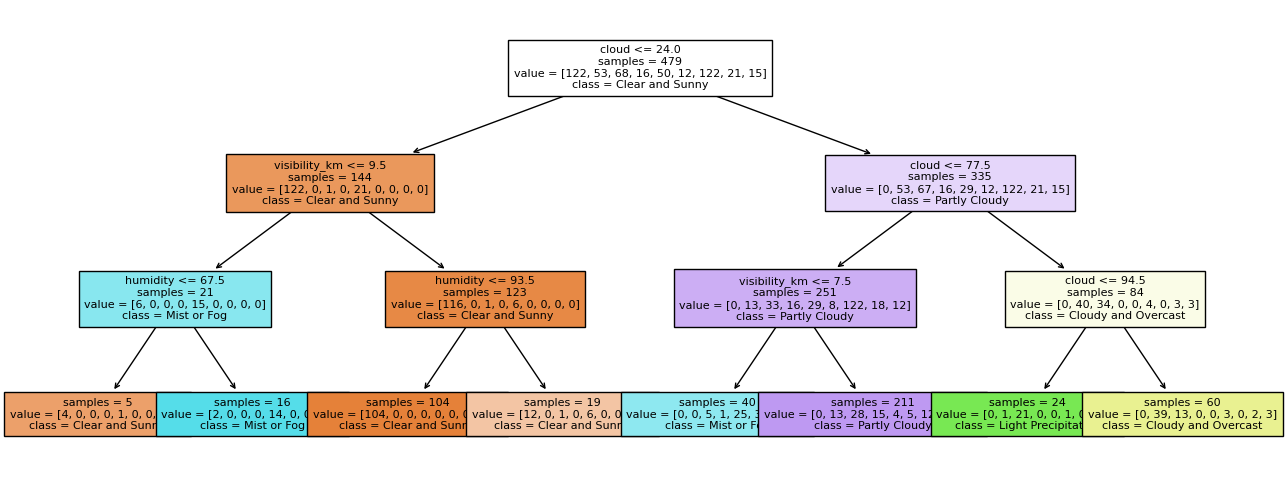

In [126]:
label_encoder = LabelEncoder()
label_encoder.fit(df3['condition_text'])

initial_features = ['temperature_celsius', 'wind_kph', 'wind_degree', 'pressure_mb', 
                    'precip_mm', 'humidity','cloud', 'feels_like_celsius', 
                    'visibility_km', 'uv_index', 'gust_kph', 'air_quality_us-epa-index', 
                    'day_length', 'relative_temperature', 'temp_humidity_interaction', 'wind_chill']

# Create DecisionTreeClassifier with max_depth=5
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(df3[initial_features], df3['condition_text'])

plt.figure(figsize=(16, 6))
plot_tree(dt, feature_names=initial_features, class_names=label_encoder.classes_, fontsize=8, impurity=False, filled=True, ax=plt.gca())
plt.show()


**The three most important features** - 
This decision tree shows us the three most important predictive features: cloud, visibility_km, humidity

In [10]:
##Let's look at a heatmap to remove highly correlated features
##df1 is created for visualization purposes
df1=df.copy()
df1.drop(['sunrise', 'sunset','sunrise_x','sunset_x', 'day_id','city_id','condition_text'], axis=1, inplace=True)

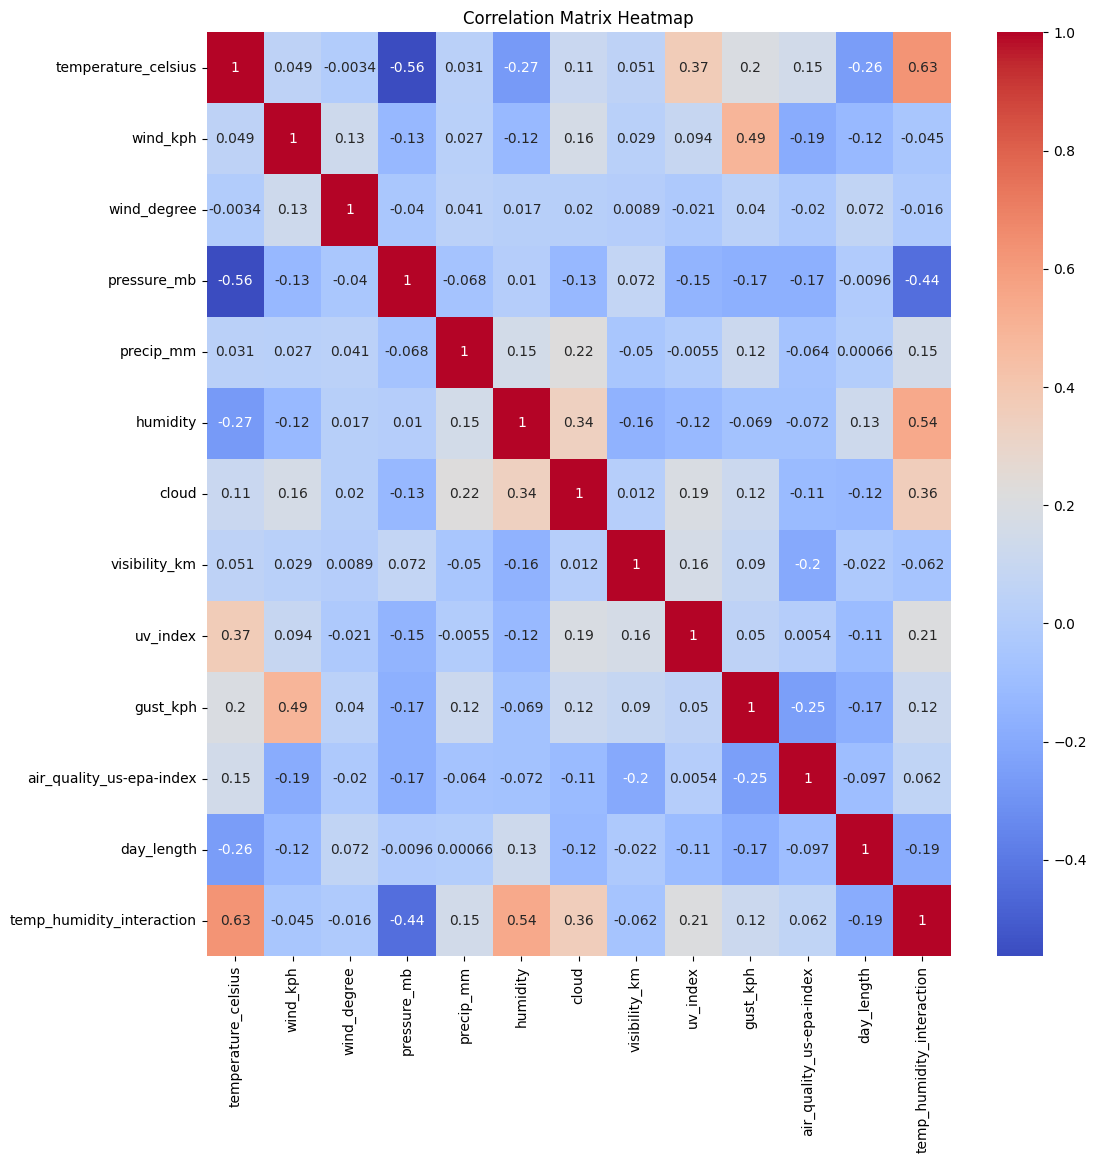

In [13]:
corr_matrix = df1.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

After drawing the heatmap, due to the high correlation among 'feels_like_celsius', 'relative_temperature', 'wind_chill' these features, removed from the dataset.

In [11]:
df1.drop(['feels_like_celsius','relative_temperature','wind_chill'], axis=1, inplace=True)

In [82]:
df2=df.copy()
df2.drop(['sunrise', 'sunset','sunrise_x','sunset_x', 'day_id', 'feels_like_celsius','relative_temperature','wind_chill'], axis=1, inplace=True)

Numerical feature are scaled using standard scaler, and all the city identifiers were one-hot encoded.

In [83]:
scaler = StandardScaler()
num_features = ['temperature_celsius','wind_kph', 'wind_degree', 'pressure_mb',
       'precip_mm', 'humidity', 'cloud', 'visibility_km', 'uv_index',
       'gust_kph', 'air_quality_us-epa-index', 'day_length', 'temp_humidity_interaction']
df2[num_features] = scaler.fit_transform(df2[num_features])

df2 = pd.get_dummies(df2, columns=['city_id'], drop_first=True)
dummy_columns = [col for col in df2.columns if 'city_id' in col]
df2[dummy_columns] = df2[dummy_columns].astype(int)

Target column is mapped.

In [84]:
category_map = {
    'Light Rain with Thunder': 0,
    'Clear and Sunny': 1,
    'Partly Cloudy': 2,
    'Light Precipitation': 3,
    'Cloudy and Overcast': 4,
    'Mist or Fog': 5,
    'Rain Showers': 6,
    'Moderate to Heavy Rain': 7,
    'Thunderstorms': 8,
}

df2['category'] = df2['condition_text'].map(category_map)
df2.drop(['condition_text'], axis=1, inplace=True)

Train, test sets were splitted such that the train set is where the category is defined.

In [86]:
# Create a mask to identify rows where 'category' column has a value
mask = df2['category'].notna()

In [87]:
# Split the DataFrame into train_df and test_df
train_df = df2[mask].copy()
test_df = df2[~mask].copy()

In [90]:
# Split train_df into X_train (features) and y_train (target)
X_train = train_df.iloc[:, :-1]  # All columns except the last one
y_train = train_df.iloc[:, -1]   # The last column

In [92]:
assert len(X_train) == len(y_train), "X_train and y_train must have the same number of samples."

In [91]:
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

# Ensure there are no missing values in y_train
print(f"Number of missing values in y_train: {y_train.isnull().sum()}")

Length of X_train: 479
Length of y_train: 479
Number of missing values in y_train: 0


In [94]:
MLA = [
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    # GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    # Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # XGBoost
    XGBClassifier()    
]

# Split dataset in cross-validation with the splitter class
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.7, random_state=0)

# Create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = y_train.copy()

# Index through MLA and save performance to table
row_index = 0
for alg in MLA:
    # Set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross-validation
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std() * 3
    
    # Save MLA predictions
    alg.fit(X_train, y_train)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index += 1

# Print and sort table
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
print(MLA_compare)

                         MLA Name  \
20                  XGBClassifier   
3      GradientBoostingClassifier   
1               BaggingClassifier   
4          RandomForestClassifier   
2            ExtraTreesClassifier   
16         DecisionTreeClassifier   
6            LogisticRegressionCV   
15                      LinearSVC   
14                            SVC   
9                   SGDClassifier   
10                     Perceptron   
5       GaussianProcessClassifier   
8               RidgeClassifierCV   
7     PassiveAggressiveClassifier   
13           KNeighborsClassifier   
18     LinearDiscriminantAnalysis   
11                    BernoulliNB   
17            ExtraTreeClassifier   
19  QuadraticDiscriminantAnalysis   
0              AdaBoostClassifier   
12                     GaussianNB   

                                       MLA Parameters MLA Train Accuracy Mean  \
20  {'objective': 'binary:logistic', 'base_score':...                     1.0   
3   {'ccp_alpha': 0.0, 

Text(0, 0.5, 'Algorithm')

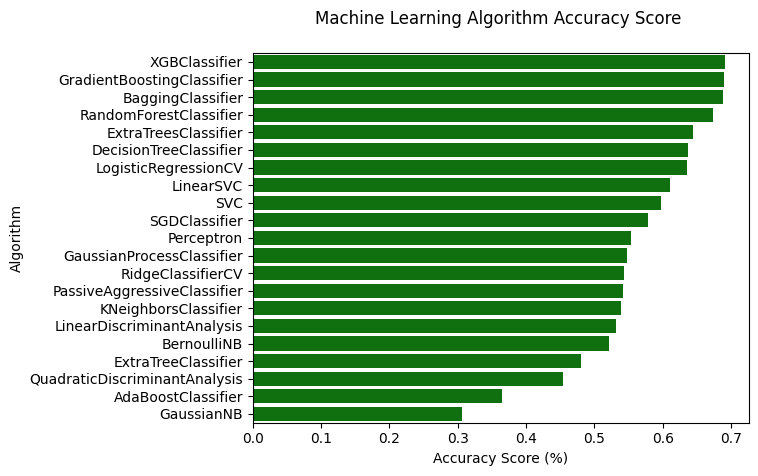

In [96]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'g')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [97]:
vote_est = [
   ('xgb', XGBClassifier()),  
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('bc', ensemble.BaggingClassifier()),    
    ('rfc', ensemble.RandomForestClassifier()),
    ('etc',ensemble.ExtraTreesClassifier())   

]

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, y_train, cv  = cv_split, return_train_score=True)
vote_hard.fit(X_train, y_train)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X_train, y_train, cv  = cv_split, return_train_score=True)
vote_soft.fit(X_train, y_train)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 100.00
Hard Voting Test w/bin score mean: 70.56
Hard Voting Test w/bin score 3*std: +/- 6.40
----------
Soft Voting Training w/bin score mean: 100.00
Soft Voting Test w/bin score mean: 70.21
Soft Voting Test w/bin score 3*std: +/- 6.55
----------


In [98]:
#Hyperparameter Tune with GridSearchCV
grid_n_estimator = [10, 50, 100]
grid_ratio = [.1, .25, .5]
grid_learn = [.01, .03, .05]
grid_max_depth = [2, 4, 6, 8]
grid_min_samples = [5, 10, .03, .05]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

import time

grid_param = [                 
            [{
            #XGBClassifier 
            'learning_rate': grid_learn, #default: .3
            'max_depth': [2,4,6,8], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }],  
    
            [{
            #GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [100], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],
    
            [{
            #BaggingClassifier 
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],
    
            [{
            #RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],   
    
            [{
            #ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }]   
        ]

start_total = time.perf_counter()
for clf, param in zip (vote_est, grid_param): 

    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X_train, y_train)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 10, 'seed': 0} with a runtime of 163.75 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'random_state': 0} with a runtime of 127.43 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.1, 'n_estimators': 10, 'random_state': 0} with a runtime of 18.18 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10, 'oob_score': True, 'random_state': 0} with a runtime of 43.01 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10, 'random_state': 0} with a runtime of 24.16 seconds.
Total optimization time was 6.28 minutes.
----------


In [99]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, X_train, y_train, cv  = cv_split, return_train_score=True)
grid_hard.fit(X_train, y_train)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv  = cv_split, return_train_score=True)
grid_soft.fit(X_train, y_train)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 67.70
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 62.08
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 12.01
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 80.15
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 68.06
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.97
----------


In [128]:
X_test = test_df.iloc[:, :-1]  # All columns except the last one
y_test = test_df.iloc[:, -1] 

In [138]:
pred = grid_soft.predict(X_test)

In [139]:
mask = df2['category'].isna()

# Replace NaN values with predictions
df2.loc[mask, 'category'] = pred

In [141]:
category_map_rev = {
    0:'Light Rain with Thunder',
    1:'Clear and Sunny',
    2:'Partly Cloudy',
    3:'Light Precipitation',
    4:'Cloudy and Overcast',
    5:'Mist or Fog',
    6:'Rain Showers',
    7:'Moderate to Heavy Rain',
    8:'Thunderstorms'
}

df2['condition_text'] = df2['category'].map(category_map_rev)

In [144]:
submission_df = pd.DataFrame({
    'day_id': df['day_id'],
    'condition_text': df2['condition_text']
})

submission_df.to_csv('submission.csv', index=False)

print("Submission file saved successfully.")

Submission file saved successfully.


In [145]:
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv